## Light-curve fitting

In [1]:
import sncosmo
import pandas as pd
import time
from astropy.table import Table
from astropy import wcs, units as u
from sncosmo.bandpasses import read_bandpass
from contextlib import contextmanager
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    
    print('[{}] {}'.format(time.time() - s, name))

# template to use
model_type = 'salt2-extended'

# only use data with signal-to-noise ratio (flux / flux_err) greater than this value
minsnr = 3


In [2]:
with timer('load data'):
    lc = pd.read_csv('../input/training_set.csv', nrows=10000)
    meta = pd.read_csv('../input/training_set_metadata.csv')
    meta.set_index('object_id', inplace=True)

[0.030917644500732422] load data


## Prepare columns required by sncosmo
see https://sncosmo.readthedocs.io/en/v1.6.x/photdata.html in detail.

In [18]:
passbands = ['lsstu','lsstg','lsstr','lssti','lsstz','lssty']

with timer('prep'):
    lc['band'] = lc['passband'].apply(lambda x: passbands[x])
    lc['zpsys'] = 'ab'
    lc['zp'] = 25.0

[0.003989696502685547] prep


## Fitting the light curve and show model

We can simply call [fit_lc](https://sncosmo.readthedocs.io/en/v1.6.x/api/sncosmo.fit_lc.html) API to get model parameters. 

chisq:1320.1221442040792
hostgal_photoz: 0.182, hostgal_specz: 0.1352, estimated z by the model: 0.1497690466904747


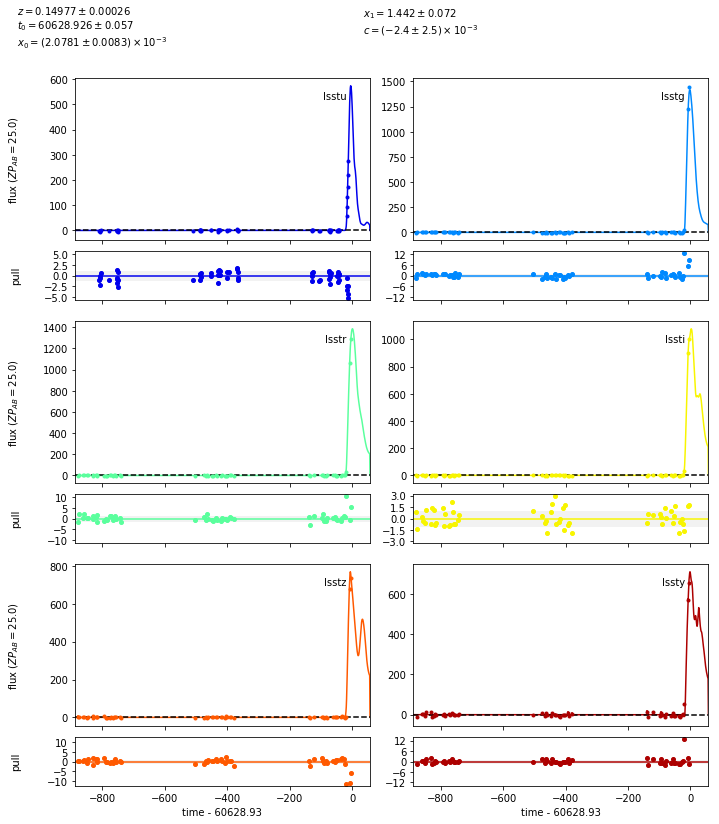

In [7]:
object_id = 1598

# create a model
model = sncosmo.Model(source=model_type)
data = Table.from_pandas(lc[lc.object_id == object_id])

# run the fit
result, fitted_model = sncosmo.fit_lc(
    data, model,
    model.param_names,
    bounds={'z':(0.0, 1.4)},
    minsnr=minsnr)  # bounds on parameters

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, xfigsize=10)


print('chisq:{}'.format(result.chisq))
print('hostgal_photoz: {}, hostgal_specz: {}, estimated z by the model: {}'.format(meta.loc[object_id,'hostgal_photoz'],
                                                                                   meta.loc[object_id,'hostgal_specz'],
                                                                                   result.parameters[0]))

We can use estimated parameters ([z, t0, x0, x1, c] in SALT-2) as a feature. We can also use it's chi^2 value ((estimated flux - actual flux)^2 / flux_err) as an additional feature. Chisq from template fit model is popular feature in the similar problem (see p.16 in [SNPhotCC competition summary](https://arxiv.org/pdf/1008.1024.pdf), and figure 11.5 in [LSST Science Book](https://www.lsst.org/sites/default/files/docs/sciencebook/SB_11.pdf). Someone also referred about it in [discussion](https://www.kaggle.com/c/PLAsTiCC-2018/discussion/70669#417141))

In [17]:
feature_df = pd.DataFrame(columns=result.param_names+['chisq'])
feature_df.loc[object_id] = list(result.parameters) + [result.chisq]
feature_df

,z,t0,x0,x1,c,chisq
1598,0.149769,60628.926106,0.002078,1.442116,-0.002391,1320.122144
